This is for using 4 channels, one brightfield and 3 fluorescent in the autoencoder.

### This is using compensated images
- Data directory: '/media/cjw/Data/cyto/mmFromTifs3/'
- Checkpoint directory;: "/media/cjw/Data/cyto/Checkpoints/2018-04-17-Chs-0-1-2-4_32_mmFromTifs3/checkpoint-2018-04-17-10-18-24/"
- Checkpoint file: 'autoencoder-256x-13980.meta'

In [1]:
import sys

In [2]:
sys.executable

'/home/cjw/anaconda3/envs/deep/bin/python'

In [3]:
'''
Import the modules that will be used
'''

import sys
import warnings
from distutils.version import LooseVersion
import os

import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import hdbscan

from autoencoder import network
from autoencoder import utils

%matplotlib inline
%pwd

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'/media/cjw/PythonLib/cjwdeeplearning/autoencoder/AutoEncoder_Compensated'

In [4]:
tf.__version__

'1.8.0'

In [5]:
datadir =  '/media/cjw/Data/cyto/mmCompensatedTifs/'
#datadir =  '/media/cjw/Data/cyto/ChannelOne/'

#cp_dir = '/home/cjw/disk2cjw/PythonLib/cjwdeeplearning/autoencoder/checkpoint-2018-03-19-11-19-18/'

cp_dir = "/media/cjw/Data/cyto/Checkpoints/2018-05-22-Denoise/checkpoint-2018-05-22-16-05-11/"
aemeta = 'autoencoder-256x-56200.meta'

if os.path.exists(cp_dir + aemeta):
    print("OK")

OK


In [6]:
'''
Define the neural network that was used and define hyper-parameters.
These are needed to infer from the saved network checkpoint
'''

tf.reset_default_graph()
                  
print(cp_dir)

if os.path.exists(cp_dir):
    print("OK, exists")
else:
    print("Oh no")
#checkpoint-2018-03-02-16-31-42/'
p_width = 32
p_height = 32
p_nchannels = 4
p_channels = [0,1,3,4]
p_nepochs = 40
p_batchsize = 128
p_learning_rate = 0.0002  #.00005
p_restore = False
p_latent_size = 256
p_droprate = 0.95
p_stdev = .04

enc_sizes = [(128, 3), (256, 3), (512, 3)] 
#enc_sizes = [(128, 3), (256, 3), (512,3), (1024,3)] #, (64, 3), (128,3)] #, (32, 3), (64, 3)]
dec_sizes = list(reversed(enc_sizes))
# enc_sizes = [(64, 5), (128, 3), (256,3), (512,3)]
# dec_sizes = list(reversed(enc_sizes))

images = tf.placeholder(tf.float32, (None, p_height, p_width, p_nchannels))
z = tf.placeholder(tf.float32, (None, p_latent_size))

enc = network.encoder(images, p_latent_size, droprate=p_droprate, is_train=False,
                      nfilters=enc_sizes)
sdd = network.decoder(enc, nchannels=p_nchannels, width=p_width, droprate=p_droprate,
                      is_train=False, nfilters=dec_sizes)

loss, _, _ = network.ae_loss(images, sdd)

opt = network.model_opt(loss, p_learning_rate)

saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.import_meta_graph(cp_dir + aemeta) #autoencoder-64x-18660.meta')
saver.restore(sess, tf.train.latest_checkpoint(cp_dir + ''))


/media/cjw/Data/cyto/Checkpoints/2018-05-22-Denoise/checkpoint-2018-05-22-16-05-11/
OK, exists
Encoder False
isize:  4 32
dh0 (?, 32, 32, 4)
Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) Tensor("add_5:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from /media/cjw/Data/cyto/Checkpoints/2018-05-22-Denoise/checkpoint-2018-05-22-16-05-11/autoencoder-256x-56200


In [8]:
#datadir = "/media/cjw/Data/cyto/mmFromTifs/"
#datadir = "/home/cjw/disk2cjw/Data/yeast/"
mmfiles = utils.list_mmfiles(datadir)
print(mmfiles)

mmdict = dict()

n_all_images = 0
for mmfilename in mmfiles:
#mmfilename = datadir + "Fish6_15_cjw_mean_zero.mm"
#mmfilename = datadir + "mmplate15-1.mm"
    mmheader = np.memmap(mmfilename, dtype="int32", mode='r',
                    shape=(4,))

    header_shape = mmheader.shape
    print(header_shape, mmheader)
    xshape = [mmheader[0], mmheader[1], mmheader[2], mmheader[3]]
    xshape = tuple(xshape)
    del mmheader
    n_all_images += xshape[0]
    
    m3 = np.memmap(mmfilename, dtype='float32', offset=128,
              mode='r', shape=xshape)
    key = mmfilename.split("/")[-1]
    mmdict[key] = m3

print(n_all_images)
mmdict.keys()

['/media/cjw/Data/cyto/mmCompensatedTifs/Fish3_CCB.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish4_ICE.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish3_Untreated.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish6_Untreated.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish2_Untreated.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish1_Ice.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish5_Untreated.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish6_ICE.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish4_CCB.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish6_CCB.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish2_CCB.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish1_Untreated.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish4_Untreated.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish2_ICE.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish5_CCB.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish3_ICE.mm', '/media/cjw/Data/cyto/mmCompensatedTifs/Fish1_CCB.mm', '/media/cjw/Data/cyto/mmComp

dict_keys(['Fish3_CCB.mm', 'Fish4_ICE.mm', 'Fish3_Untreated.mm', 'Fish6_Untreated.mm', 'Fish2_Untreated.mm', 'Fish1_Ice.mm', 'Fish5_Untreated.mm', 'Fish6_ICE.mm', 'Fish4_CCB.mm', 'Fish6_CCB.mm', 'Fish2_CCB.mm', 'Fish1_Untreated.mm', 'Fish4_Untreated.mm', 'Fish2_ICE.mm', 'Fish5_CCB.mm', 'Fish3_ICE.mm', 'Fish1_CCB.mm', 'Fish5_ICE.mm'])

In [9]:
n = xshape[0]
all_ids =  range(n_all_images)
idx = 0
dataframes = list()
for key in mmdict.keys():
    mm = mmdict[key]
    n = mm.shape[0]
    print(n)
    file = n*[key[0:-3]]
    fid = range(n)
    mmfile = n*[key]
    plate = n*[0]
    row = n*[0]
    column = n*[0]
    field = n*[0]
    yc = n*[32]
    xc = n*[32]
    well = n*[0]
    ids = all_ids[idx:idx + n]
    idx += n
    xdf = pd.DataFrame({'id':ids, 'fid':fid, 'file':file, 'mmfile':mmfile, 'plate':plate,
                     'row':row, 'column':column, 'field':field,
                      'yc':yc, 'xc':xc, 'well':well})

    dataframes.append(xdf)
    
alldf = pd.concat(dataframes, ignore_index=True)
trts = list()
runs = list()

for row in range(len(alldf)):
    file = alldf.iloc[row]['file']
    if '_ice' in file.lower():
        treatment = 'ice'
    elif '_ccb'in file.lower():
        treatment = 'ccb'
    else:
        treatment = "untreated"
    trts.append(treatment)
    runs.append(file[0:5])

alldf['treatment'] = trts
alldf['run'] = runs
df = alldf.sample(frac=.01)
df = df.reset_index()
print(len(df))
df.tail()

10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
1800


,index,column,fid,field,file,id,mmfile,plate,row,well,xc,yc,treatment,run
1795,104030,0,4030,0,Fish2_CCB,104030,Fish2_CCB.mm,0,0,0,32,32,ccb,Fish2
1796,110890,0,890,0,Fish1_Untreated,110890,Fish1_Untreated.mm,0,0,0,32,32,untreated,Fish1
1797,51536,0,1536,0,Fish1_Ice,51536,Fish1_Ice.mm,0,0,0,32,32,ice,Fish1
1798,1358,0,1358,0,Fish3_CCB,1358,Fish3_CCB.mm,0,0,0,32,32,ccb,Fish3
1799,22341,0,2341,0,Fish3_Untreated,22341,Fish3_Untreated.mm,0,0,0,32,32,untreated,Fish3


In [10]:
sns.set_style("whitegrid", {'axes.grid' : False})
len(df)

1800

In [11]:
'''Read the images, display image, encode and show latent space, show decoded'''

vv = utils.getWell(mmdict,
                    df, p_width, 0, 0, p_nchannels, channels=p_channels)

nvv = len(vv)
offloc = 0
offstep = 1000
offnext = offloc + offstep
xhe = np.zeros((nvv, p_latent_size))
xdd = np.zeros((nvv, p_width, p_height, p_nchannels))
while offloc < nvv:
    #print(offloc, offnext)
    xhe[offloc:offnext] = sess.run(enc, feed_dict={images:vv[offloc:offnext]})
    xdd[offloc:offnext] = sess.run(sdd, feed_dict={enc:xhe[offloc:offnext]})
    offloc = offnext
    offnext += offstep
    if offnext > nvv:
        offnext = nvv
        
f = plt.figure(figsize=(12, 40))
print(xhe.shape, xdd.shape)
print(np.amin(vv),np.amax(vv))
# for i in range(5):
#     ix = np.random.randint(0, len(vv))
#     #print(ix)
#     plt.subplot(20,3,i*3 + 1)
#     plt.imshow(vv[ix,:,:,0])
#     plt.subplot(20,3,i*3 + 2)
#     plt.plot(xhe[ix])
#     plt.subplot(20,3,i*3 + 3)
#     plt.imshow(xdd[ix,:,:,0])
   

(1800, 256) (1800, 32, 32, 4)
0.06112608686089516 0.9715520739555359


<Figure size 864x2880 with 0 Axes>

In [12]:
xhemm = np.memmap('/media/cjw/Data/cyto/latent_space_256.mm', dtype=np.float32, mode='w+', shape=xhe.shape)
xhemm[:] = xhe[:]
del xhemm

In [12]:
def one_imshow(image, r, c, ic, cmap):
    plt.subplot(16, 8, ic)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')

ic = 1

nrows = 6
plt.figure(figsize=(16,4*nrows))

# for i in range(nrows):
#     ix = np.random.randint(0, len(vv))
#     one_imshow(vv[ix,:,:,0], nrows, 8, ic, 'gray')
#     ic += 1
    
#     one_imshow(vv[ix,:,:,1], nrows, 8, ic, 'viridis')
#     ic += 1
    
#     one_imshow(vv[ix,:,:,2], nrows, 8, ic, 'plasma')
#     ic += 1
    
#     one_imshow(vv[ix,:,:,3], nrows, 8, ic, 'afmhot')
#     ic += 1
    
#     one_imshow(xdd[ix,:,:,0], nrows, 8, ic, 'gray')
#     ic += 1
    
#     one_imshow(xdd[ix,:,:,1], nrows, 8, ic, 'viridis')
#     ic += 1
    
#     one_imshow(xdd[ix,:,:,2], nrows, 8, ic, 'plasma')
#     ic += 1
    
#     one_imshow(xdd[ix,:,:,3], nrows, 8, ic, 'afmhot')
#     ic += 1

#plt.savefig('/media/cjw/Data/cyto/output/decoded.png')

<Figure size 1152x1728 with 0 Axes>

<Figure size 1152x1728 with 0 Axes>

In [13]:
'''Encode the images with the trained network and store the latent spaces in an array'''

dv = {0:(0,0)}
dimages = dict()
counter = 0
one = 0
for k in dv.keys():
    i, j = dv[k]
    print(i, j)
    r = i + 1
    cm = j + 1
    try:
        k = vv #utils.getWell(mmdict,df, width, 0, 0, nchannels, channels=[0])
        print(len(k))
    except:
        print("Oh no!!")
        continue
    hek = xhe #sess.run(enc, feed_dict={images:k})
    print('hek', hek.shape)
    dimages[counter] = k
    if one == 0:
        one = 1
        g = hek
        colors = np.zeros(k.shape[0])
        counter += 1
        print(i, j, g.shape, hek.shape)
    else:
        print(i, j, g.shape, hek.shape)
        g = np.concatenate((g,hek))
        colors = np.concatenate((colors, counter + np.zeros(k.shape[0])))
        counter += 1

g_all = g
g_all.shape

0 0
1800
hek (1800, 256)
0 0 (1800, 256) (1800, 256)


(1800, 256)

In [15]:
ops = sess.graph.get_operations()
for op in ops:
    print(op.values())


(<tf.Tensor 'Placeholder:0' shape=(?, 32, 32, 4) dtype=float32>,)
(<tf.Tensor 'Placeholder_1:0' shape=(?, 256) dtype=float32>,)
(<tf.Tensor 'filter_00/kernel/Initializer/truncated_normal/shape:0' shape=(4,) dtype=int32>,)
(<tf.Tensor 'filter_00/kernel/Initializer/truncated_normal/mean:0' shape=() dtype=float32>,)
(<tf.Tensor 'filter_00/kernel/Initializer/truncated_normal/stddev:0' shape=() dtype=float32>,)
(<tf.Tensor 'filter_00/kernel/Initializer/truncated_normal/TruncatedNormal:0' shape=(3, 3, 4, 128) dtype=float32>,)
(<tf.Tensor 'filter_00/kernel/Initializer/truncated_normal/mul:0' shape=(3, 3, 4, 128) dtype=float32>,)
(<tf.Tensor 'filter_00/kernel/Initializer/truncated_normal:0' shape=(3, 3, 4, 128) dtype=float32>,)
(<tf.Tensor 'filter_00/kernel:0' shape=(3, 3, 4, 128) dtype=float32_ref>,)
(<tf.Tensor 'filter_00/kernel/Assign:0' shape=(3, 3, 4, 128) dtype=float32_ref>,)
(<tf.Tensor 'filter_00/kernel/read:0' shape=(3, 3, 4, 128) dtype=float32>,)
(<tf.Tensor 'filter_00/bias/Initializ

(<tf.Tensor 'conv2d_transpose_1/bias/Adam_1/read:0' shape=(128,) dtype=float32>,)
(<tf.Tensor 'decoder_out/kernel/Adam/Initializer/zeros/shape_as_tensor:0' shape=(4,) dtype=int32>,)
(<tf.Tensor 'decoder_out/kernel/Adam/Initializer/zeros/Const:0' shape=() dtype=float32>,)
(<tf.Tensor 'decoder_out/kernel/Adam/Initializer/zeros:0' shape=(5, 5, 4, 128) dtype=float32>,)
(<tf.Tensor 'decoder_out/kernel/Adam:0' shape=(5, 5, 4, 128) dtype=float32_ref>,)
(<tf.Tensor 'decoder_out/kernel/Adam/Assign:0' shape=(5, 5, 4, 128) dtype=float32_ref>,)
(<tf.Tensor 'decoder_out/kernel/Adam/read:0' shape=(5, 5, 4, 128) dtype=float32>,)
(<tf.Tensor 'decoder_out/kernel/Adam_1/Initializer/zeros/shape_as_tensor:0' shape=(4,) dtype=int32>,)
(<tf.Tensor 'decoder_out/kernel/Adam_1/Initializer/zeros/Const:0' shape=() dtype=float32>,)
(<tf.Tensor 'decoder_out/kernel/Adam_1/Initializer/zeros:0' shape=(5, 5, 4, 128) dtype=float32>,)
(<tf.Tensor 'decoder_out/kernel/Adam_1:0' shape=(5, 5, 4, 128) dtype=float32_ref>,)
(<

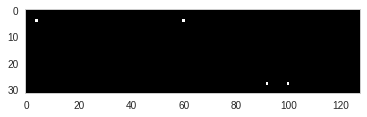

In [197]:
inum = 107
samp = np.zeros((1,32,32,4))
samp[0,4, 4, 0] = .8
samp[0,4, 28, 1] = .8
samp[0,28, 28, 2] = .8
samp[0,28, 4, 3] = .8
filt, kern = sess.run([tf.get_default_graph().get_tensor_by_name('mul:0'),
                tf.get_default_graph().get_tensor_by_name('filter_00/kernel:0')],
                feed_dict={images:samp}) #vv[inum:inum + 1]})

th = np.zeros((32,32*4))
th[0:32,0:32] = samp[0,:,:,0] #vv[inum,:,:,0]
th[0:32,32:64] = samp[0,:,:,1] #vv[inum,:,:,1]
th[0:32,64:96] = samp[0,:,:,2] #vv[inum,:,:,2]
th[0:32,96:128] = samp[0,:,:,3] #vv[inum,:,:,3]
plt.imshow(th, cmap='gray')

(3, 3, 4, 128)

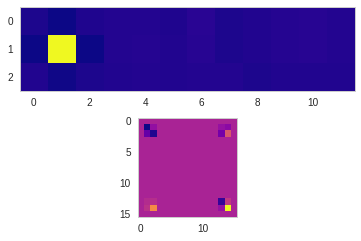

In [202]:
ki = 43
kz = np.zeros((3,12))
kz[0:3, 0:3] = kern[:,:,0,ki]
kz[0:3, 3:6] = kern[:,:,1,ki]
kz[0:3, 6:9] = kern[:,:,2,ki]
kz[0:3, 9:12] = kern[:,:,3,ki]
plt.subplot(2,1,1)
plt.imshow(kz, cmap='plasma')
plt.subplot(2,1,2)
plt.imshow(filt[0,:,:,ki], cmap='plasma')
# plt.subplot(2,4,6)
# plt.imshow(filt[0,:,:,ki], cmap='gray')
# plt.subplot(2,4,7)
# plt.imshow(filt[0,:,:,ki], cmap='gray')
# plt.subplot(2,4,8)
# plt.imshow(filt[0,:,:,ki], cmap='gray')

kern.shape

(1, 16, 16, 128)
[  0  16  32  48  64  80  96 112]
[  0  16  32  48  64  80  96 112 128 144 160 176 192 208 224 240]


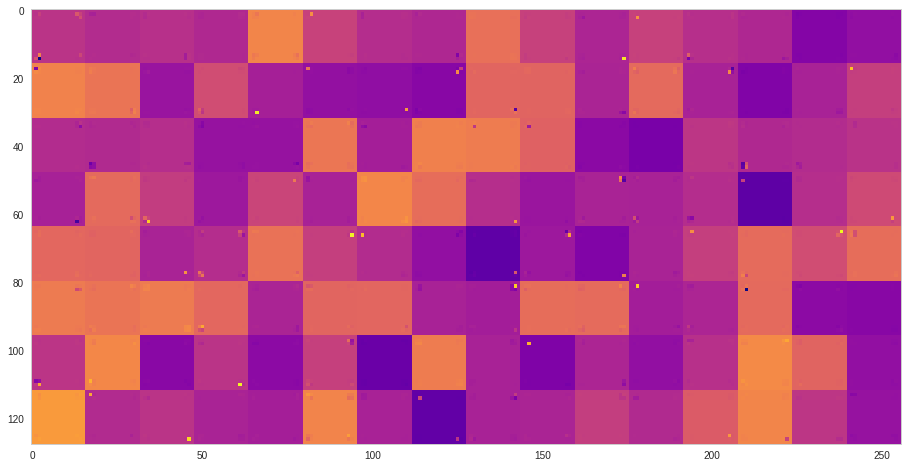

In [191]:
print(filt.shape)

sz = 16
p = np.zeros((sz*8, sz*16))

e0 = np.arange(0, sz*8, sz)
e1 = np.arange(0, sz*16, sz)
print(e0)
print(e1)
index = 0
for i in e0:
    for j  in e1:
        p[i:i+sz, j:j+sz] = filt[0,:,:,index]
        index += 1
plt.figure(figsize=(sz,sz/2))
plt.imshow(p, cmap='plasma')

In [13]:
''' Create some colors for display later on'''

from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
clist = [(.2,.2,.2),
         (172/255,25/255,210/255),
         (255/255, 165./255, 0),
         (44/255,25/255,210/255),
         (134/255, 165./255, 56/255),
         (26/255,188/255,255/255),
         (188/255,255/255, 26/255),
         (1, 0,0), (0,1,0), (0,0,1)]

mycmap = LinearSegmentedColormap.from_list(
        'mycmap', clist, N=len(clist))

bounds = np.linspace(0, len(clist), len(clist) + 1)
norm = mpl.colors.BoundaryNorm(bounds, mycmap.N)
print(bounds, mycmap.N)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] 10


In [14]:
'''Do PCA on the latent space features'''

from sklearn.decomposition import PCA
pca = PCA(n_components=64, svd_solver='arpack', whiten=True, copy=True)
gfit = pca.fit_transform(g_all)
print(gfit.shape)
print(pca.explained_variance_)
print(pca.components_.shape)


(18000, 64)
[0.11008501 0.07136802 0.06589075 0.05673786 0.05155109 0.04438412
 0.04190311 0.03842763 0.03745824 0.03690231 0.03195241 0.03134982
 0.0297536  0.0287476  0.02686675 0.02583455 0.02467051 0.02431254
 0.02353332 0.02323159 0.022384   0.02208386 0.0213653  0.0204556
 0.01952404 0.01929835 0.01900326 0.01868946 0.01820415 0.01730673
 0.01720933 0.01682728 0.01663014 0.01647029 0.01576182 0.01541852
 0.01495424 0.01478916 0.0143242  0.01429423 0.0138375  0.01362269
 0.01348224 0.01326493 0.01304541 0.01272448 0.01240187 0.01210122
 0.01181503 0.01179655 0.01167706 0.01125787 0.01118802 0.01080154
 0.0105878  0.01049468 0.01042702 0.01010787 0.0099308  0.00990179
 0.00972568 0.00958359 0.00948723 0.00936327]
(64, 256)


In [15]:
'''
Do clustering on the latent space features
find eight cluster for K-Means and Allomerative Clustering
'''

nclust = 27
from sklearn import cluster, mixture
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

km = cluster.KMeans(n_clusters=nclust).fit_predict(g_all)
agc = cluster.AgglomerativeClustering(n_clusters=nclust, affinity='euclidean', linkage="ward").fit_predict(g_all)
gmm = BayesianGaussianMixture(nclust, covariance_type='full')
gmm.fit(g_all)
gm = gmm.predict(g_all)

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


###  Show results of clustering using K-Means

Each row is a cluster found using the K-Means algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


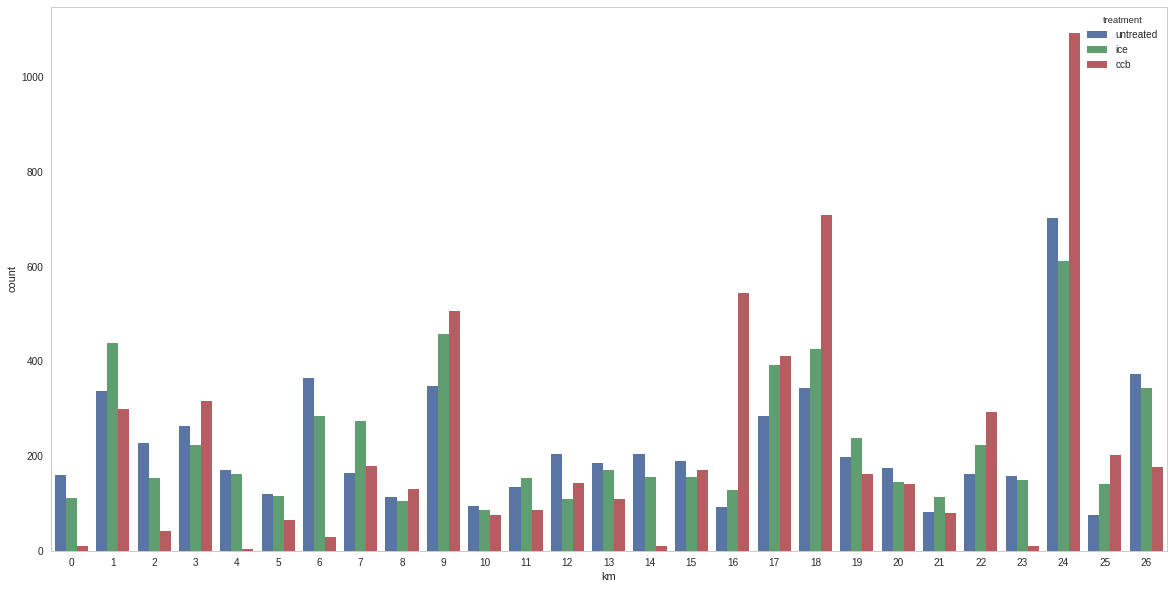

In [16]:
km = gm
df['km'] = km

plt.figure(figsize=(20,10))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.countplot(x='km', data=df, hue='treatment')

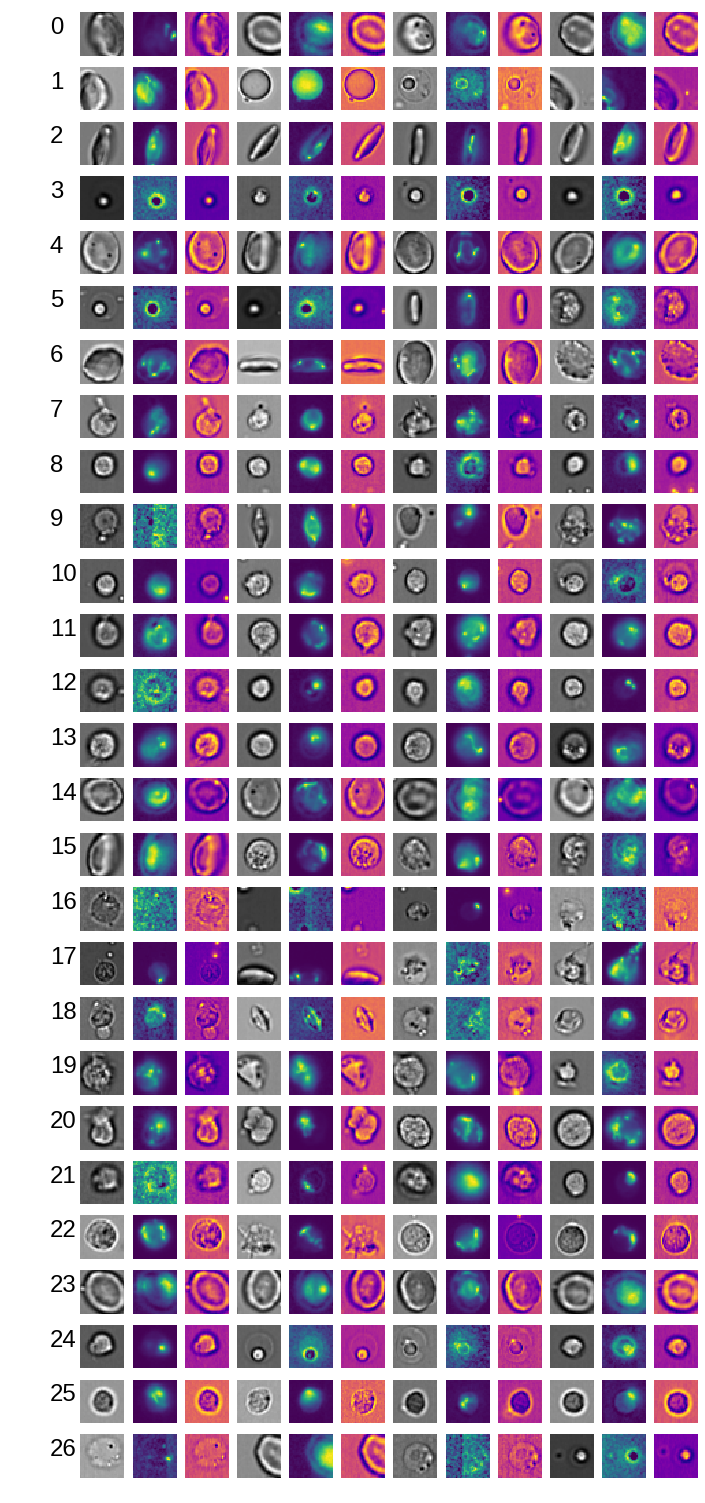

In [17]:
ximages = vv
nk = nclust
plt.figure(figsize=(12, 1.*nk))
plt.ion()
counter = 1
shift = 0
for k in range(nk):
    rowdf = df[df['km'] == k]
    inum = list(rowdf.index)
    
    gk = g_all[km == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={enc:gavk})
#     plt.subplot(nk, 12, counter)
#     plt.imshow(resav.squeeze()[0])
#     plt.text(8, 12,str(k), fontsize=36, color='black')
#     counter += 1
    plt.subplot(nk, 13, counter)
    plt.text(0.5,0.5, str(k), fontsize=24, color='black')
    plt.axis('off')
    counter += 1
    for i in range(4):
        
        try:
            plt.subplot(nk, 13, counter)
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            plt.axis('off')
            counter += 1
            plt.subplot(nk, 13, counter)
            plt.imshow(ximages[rnd,:,:,1], cmap='viridis')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            
            plt.subplot(nk, 13, counter)
            plt.imshow(ximages[rnd,:,:,2], cmap='plasma')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            #print(rnd, df.iloc[rnd]['mmfile'])
        except Exception as e:
            print(e)
            plt.imshow(np.zeros((64,64)), cmap='gray')
            counter += 1

###  Show results of clustering using Agglomerative Clustering

Each row is a cluster found using the [Agglomerative Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)
algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


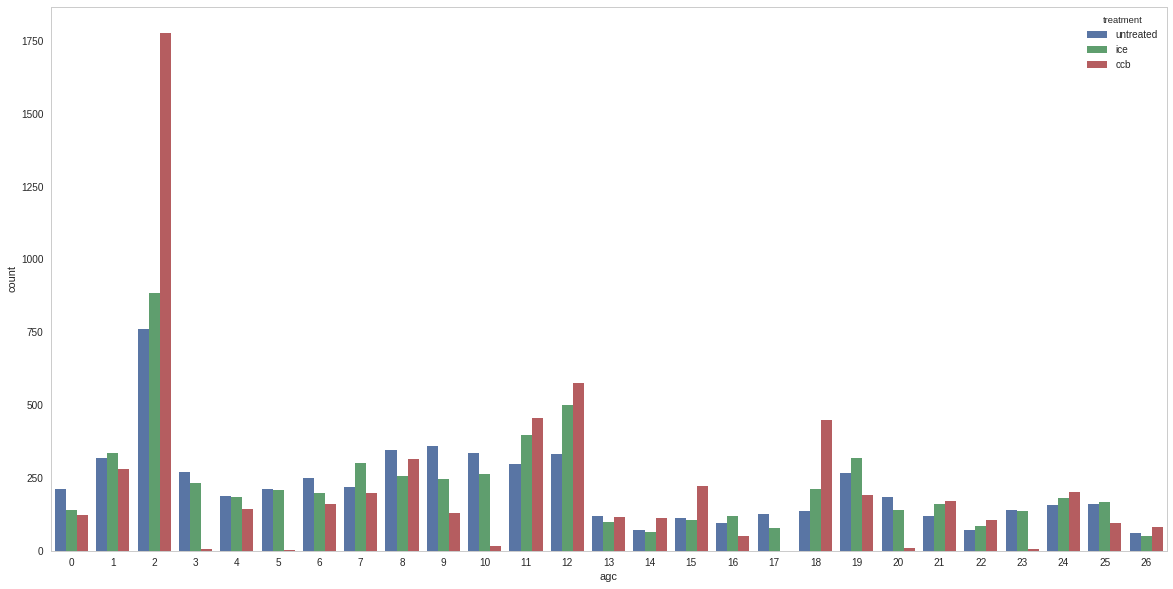

In [20]:
df['agc'] = agc
plt.figure(figsize=(20,10))
sns.countplot(x='agc', data=df, hue='treatment')
plt.savefig('/media/cjw/Data/cyto/output/agc_filedist.png')

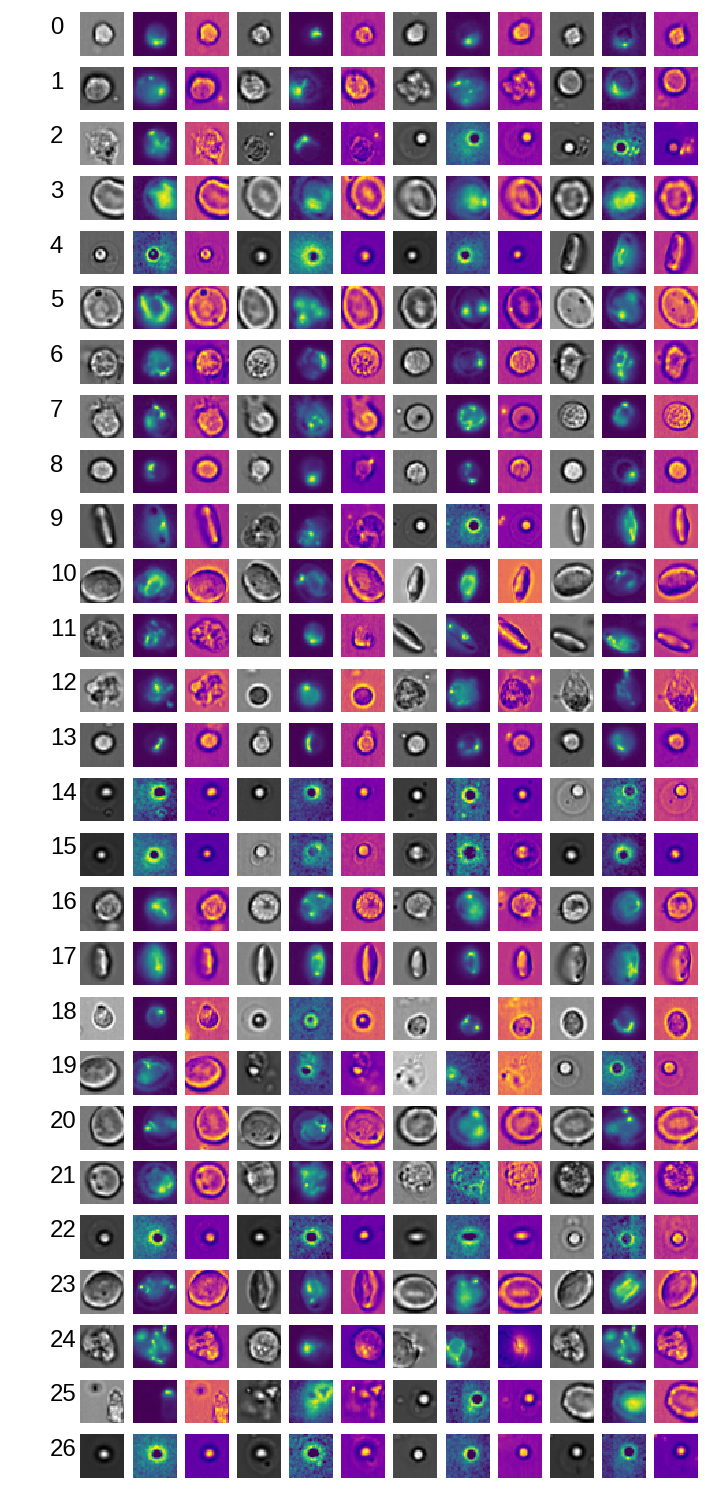

In [21]:
ximages = vv
nk = nclust
plt.figure(figsize=(12, 1.*nk))
plt.ion()
counter = 1
shift = 0
for k in range(nk):
    rowdf = df[df['agc'] == k]
    inum = list(rowdf.index)
    
    gk = g_all[agc == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={enc:gavk})
#     plt.subplot(nk, 12, counter)
#     plt.imshow(resav.squeeze()[0])
#     plt.text(8, 12,str(k), fontsize=36, color='black')
#     counter += 1
    plt.subplot(nk, 13, counter)
    plt.text(0.5,0.5, str(k), fontsize=24, color='black')
    plt.axis('off')
    counter += 1
    for i in range(4):
        
        try:
            plt.subplot(nk, 13, counter)
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            plt.axis('off')
            counter += 1
            plt.subplot(nk, 13, counter)
            plt.imshow(ximages[rnd,:,:,1], cmap='viridis')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            
            plt.subplot(nk, 13, counter)
            plt.imshow(ximages[rnd,:,:,2], cmap='plasma')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            #print(rnd, df.iloc[rnd]['mmfile'])
        except Exception as e:
            print(e)
            plt.imshow(np.zeros((64,64)), cmap='gray')
            counter += 1

-------------------------------------------------------------------------

In [19]:
import matplotlib 
def display_cluster(cluster_num, nrows=16, outfile=None):
    
    if outfile:
        plt.ioff()
    tn = cluster_num
    images4 = ximages[agc == tn]
    g4 = g_all[agc == tn]
    fig = plt.figure(figsize=(16,1.6*1.5*nrows))
    #print(images4.shape)

#     gtest = np.mean(g4, axis=0)
#     gtest = np.expand_dims(gtest.squeeze(), axis=0)
#     res = sess.run(sdd, feed_dict={enc:gtest})

#     gav = np.mean(g_all, axis=0)
#     gav = np.expand_dims(gav.squeeze(), axis=0)
#     resav = sess.run(sdd, feed_dict={enc:gav})

    ppi = 0
    for i in range(nrows):
        ix = np.random.randint(0, len(g4))
        plt.subplot(nrows,8,i*8 + 1)
        plt.imshow(images4[ix,:,:,0], cmap='gray')
        plt.axis('off')

        plt.subplot(nrows,8,i*8 + 2)
        plt.imshow(images4[ix,:,:,1], cmap='viridis')
        plt.axis('off')

        plt.subplot(nrows,8, i*8 + 3)
        plt.imshow(images4[ix,:,:,2], cmap='plasma')
        plt.axis('off')

        plt.subplot(nrows,8,i*8 + 4)
        plt.imshow(images4[ix,:,:,3], cmap='afmhot')
        plt.axis('off')

        plt.subplot(nrows, 2, i*2 + 2)
        plt.plot(g4[ix]*0, color='gray')
        plt.plot(g4[ix])

    #     plt.xticks([])
    #     plt.yticks([])
        plt.axis('off')
        ppi += 2
    if outfile:
        #fig = matplotlib.pyplot.gcf()
        #fig.set_size_inches(4, 10)
        #fig.savefig('test2png.png', dpi=100)
        plt.savefig(outfile, dpi=100)
        plt.clf()
        plt.close(fig)
    
    plt.ion()



In [20]:
for i in range(nclust):
    outfile = "/media/cjw/Data/cyto/output/cluster_" + str(i).zfill(3) + ".png"
    display_cluster(i, 8, outfile=outfile)

In [83]:
from sklearn.manifold import TSNE

# geez = list()
# ceez = list()
# cindex = 0
# for i in (16,17, 18,19):
#     gna = g_all[agc == i]
#     ca = cindex #np.array(clist[cindex])
#     cna = np.repeat([i], gna.shape[0], axis=0)
#     geez.append(gna)
#     ceez.append(cna)
#     cindex += 1
# # c3 = gn3.shape[0]*(1, 0, 0)
# # c6 = gn3.shape[0]*(0, 1, 0)
# # c10 = gn3.shape[0]*(0, 0, 1)
# gn = np.concatenate(geez)
# cn = np.concatenate(ceez)
# cn = np.concatenate((c3, c6, c10))
#print(gn.shape)
g_emb = TSNE(n_components=2,perplexity=50, learning_rate=1000).fit_transform(g_all.astype(np.float64))
print(g_emb.shape)



(9000, 2)


/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


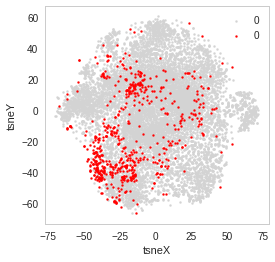

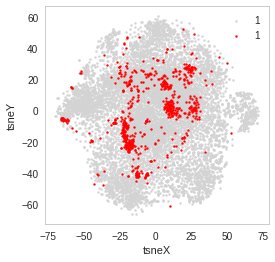

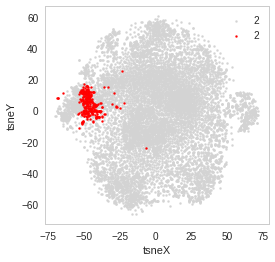

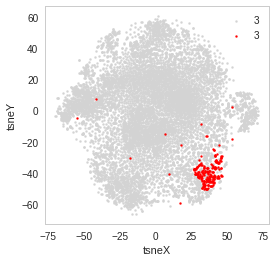

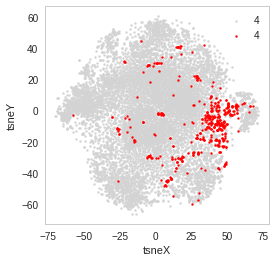

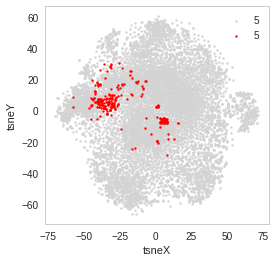

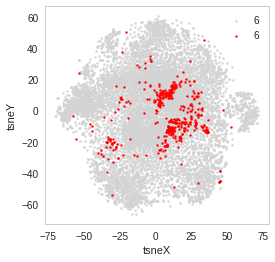

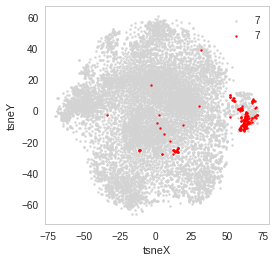

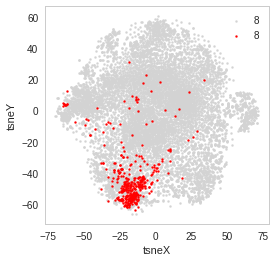

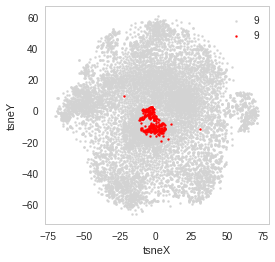

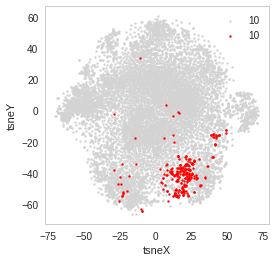

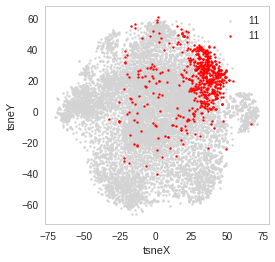

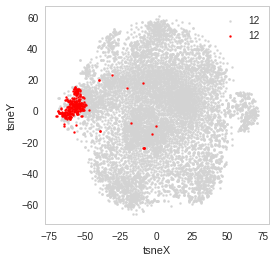

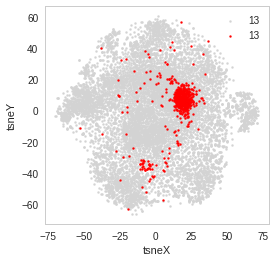

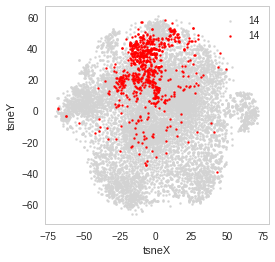

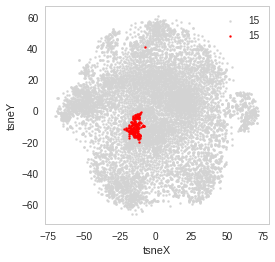

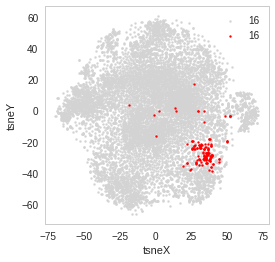

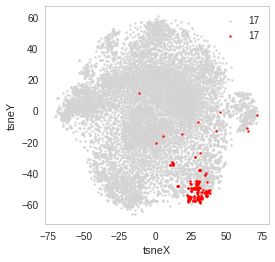

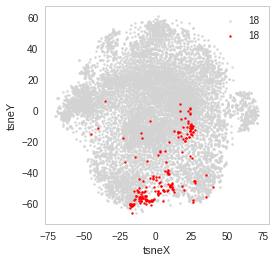

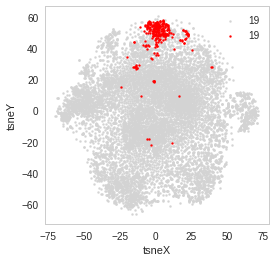

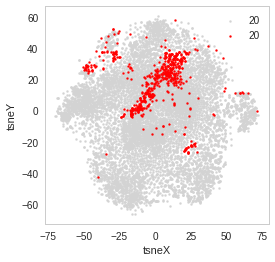

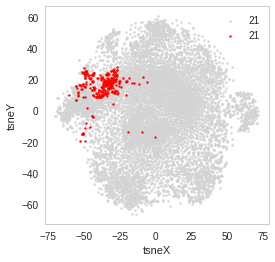

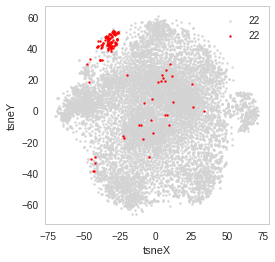

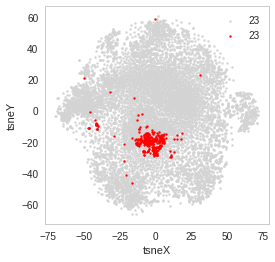

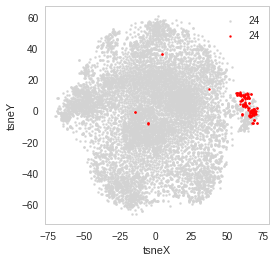

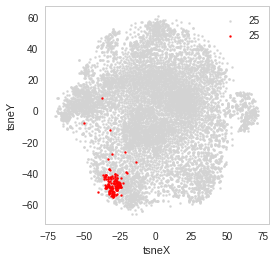

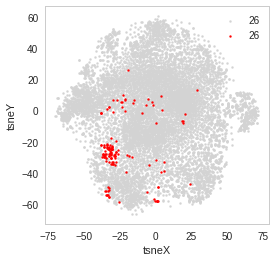

In [85]:
df['tsneX'] = g_emb[:,0]
df['tsneY'] = g_emb[:,1]

cs = ['black', 'gray', 'navy', 'blue',
      'slateblue', 'darkgreen', 'green', 'greenyellow',
     'gold', 'saddlebrown', 'salmon', 'orange']
ax = None

coi1 =  1
coi2 =  11
#plt.ioff()
for i in range(nclust):
        ax = df[df['agc'] != i].plot.scatter('tsneX', 'tsneY', label=i, s=4, color='lightgray', figsize=(4,4))
        df[df['agc'] == i].plot.scatter('tsneX', 'tsneY', label=i, s=4, color='red', ax = ax)
        outfile = "/media/cjw/Data/cyto/output/tsne_" + str(i).zfill(3) + ".png"
        plt.savefig(outfile, dpi=100)
        #plt.clf()
        #plt.close()
plt.ion()

KeyboardInterrupt: 

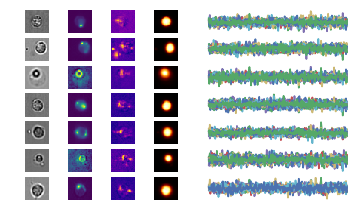